In [1]:
import torch
 
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
import json
import copy

E:\anaconda\envs\data_mining\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

pd.set_option('display.min_rows',100)  
path = '..\..\dataset\data_xyz\provinceData\上海.json' ##记得改
fr = open(path, 'r', encoding='utf-8')
json_info = fr.read()
fr.close()
data_dict = json.loads(json_info)
data = pd.DataFrame(data_dict['data'])
data = data[['confirmedCount', 'dateId']]
data['dateId'] = data['dateId'].astype(str)
data['dateId'] = pd.to_datetime(data['dateId'], format='%Y%m%d')
data.index = data['dateId']
data = data.set_index('dateId', drop=True)
data_size = int(len(data)*0.7)
test_set = data[-data_size:]
train_set = data[:data_size]
test_set = data[-(len(data)-len(train_set)):]
temp =copy.deepcopy(test_set)
train_set.head()

,confirmedCount
dateId,
2020-01-20,1
2020-01-21,9
2020-01-22,16
2020-01-23,20
2020-01-24,33


E:\anaconda\envs\data_mining\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


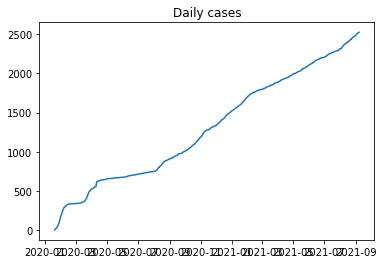

In [3]:
plt.plot(train_set)
plt.title("Daily cases");

In [4]:

scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.fit_transform(test_set)

"""
print(train_set.values.shape)
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_set, axis=1))
 
train_data = scaler.transform(np.expand_dims(train_set, axis=1))
test_data = scaler.transform(np.expand_dims(test_set, axis=1))


"""


'\nprint(train_set.values.shape)\nscaler = MinMaxScaler()\nscaler = scaler.fit(np.expand_dims(train_set, axis=1))\n \ntrain_data = scaler.transform(np.expand_dims(train_set, axis=1))\ntest_data = scaler.transform(np.expand_dims(test_set, axis=1))\n\n\n'

In [5]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
 
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
 
    return np.array(xs), np.array(ys)
 
seq_length = 7
X_train, y_train = create_sequences(train_set, seq_length)
X_test, y_test = create_sequences(test_set, seq_length)
 
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
 
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


In [6]:
class CoronaVirusPredictor(nn.Module):
 
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
 
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
 
        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5
        )
 
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
 
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
 
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [7]:
def train_model(
      model, 
      train_data, 
      train_labels, 
      test_data=None, 
      test_labels=None
    ):
    loss_fn = torch.nn.MSELoss(reduction='sum')
 
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs =100
 
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
 
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
 
            if t % 10 == 0:  
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
 
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
 
    return model.eval(), train_hist, test_hist

In [ ]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=64,
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 232.86170959472656 test loss: 25.282474517822266
Epoch 10 train loss: 72.0487289428711 test loss: 22.14387321472168
Epoch 20 train loss: 41.38821029663086 test loss: 52.92811584472656


In [ ]:
with torch.no_grad():
    i =0
    test_seq = X_test[i:i+1]
    
    preds = []
    
    for _ in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        i+=1
##        new_seq = test_seq.numpy().flatten()
##        new_seq = np.append(new_seq, [pred])
##        new_seq = new_seq[1:]
##       test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:

true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()


In [ ]:
plt.plot(
  data.index[:len(train_set)], 
  data[:len(train_set)],
  label='Historical Daily Cases')
plt.plot(
  data.index[len(train_set):len(train_set) + len(true_cases)], 
   data[len(train_set):len(train_set) + len(true_cases)],
  label='Real Daily Cases')
plt.plot(
 data.index[len(train_set):len(train_set) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases')
 
plt.legend();

In [ ]:
print( data[len(train_set):len(train_set) + len(true_cases)])
print(predicted_cases)